<a href="https://colab.research.google.com/github/BassamTar99/StockPrediction/blob/LSTM_Model/Automated_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#@title Cell 1: Install Dependencies
!pip install yfinance matplotlib tensorflow keras-tuner


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 2.6 MB/s eta 0:00:00


In [ ]:
#@title Cell 2: Imports & Reproducibility
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import keras_tuner
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import SGD, Adam, RMSprop
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

from kerastuner.tuners import RandomSearch

# Fix seeds
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)


In [ ]:
#@title Cell 3: Prompt for Ticker & Download Data
ticker = input("Enter the stock ticker (e.g. AAPL, TSLA): ").upper().strip()
start  = "2018-01-01"
end    = "2025-04-23"

df = yf.download(ticker, start=start, end=end)
if df.empty:
    raise ValueError(f"No data found for ticker '{ticker}'. Please rerun and try another.")

print(f"Downloaded {len(df)} rows for {ticker}")
df.tail()


Enter the stock ticker (e.g. AAPL, TSLA): aapl
YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed

Downloaded 1836 rows for AAPL


Price,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,
2025-04-15,202.139999,203.509995,199.800003,201.860001,51343900
2025-04-16,194.270004,200.699997,192.369995,198.360001,59732400
2025-04-17,196.979996,198.830002,194.419998,197.199997,51334300
2025-04-21,193.160004,193.800003,189.809998,193.270004,46742500
2025-04-22,199.740005,201.589996,195.970001,196.119995,52976400


In [ ]:
#@title Cell 4: Feature Engineering (Rich Inputs)
# Keep OHLCV + SMAs + RSI + MACD
df_feat = df[['Open','High','Low','Close','Volume']].copy()

# Simple Moving Averages
for w in (10,20,50):
    df_feat[f"SMA_{w}"] = df_feat['Close'].rolling(w).mean()

# RSI
rsi_w = 14
delta = df_feat['Close'].diff()
gain  = delta.clip(lower=0)
loss  = -delta.clip(upper=0)
avg_gain = gain.rolling(rsi_w).mean()
avg_loss = loss.rolling(rsi_w).mean()
rs = avg_gain / avg_loss
df_feat['RSI'] = 100 - (100 / (1 + rs))

# MACD
fast, slow, sig = 12, 26, 9
ema_fast = df_feat['Close'].ewm(span=fast, adjust=False).mean()
ema_slow = df_feat['Close'].ewm(span=slow, adjust=False).mean()
df_feat['MACD']        = ema_fast - ema_slow
df_feat['MACD_SIGNAL'] = df_feat['MACD'].ewm(span=sig, adjust=False).mean()

df_feat.dropna(inplace=True)
print("Features shape:", df_feat.shape)
df_feat.tail()


Features shape: (1787, 11)


Price,Open,High,Low,Close,Volume,SMA_10,SMA_20,SMA_50,RSI,MACD,MACD_SIGNAL
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL,,,,,,
Date,,,,,,,,,,,
2025-04-15,201.860001,203.509995,199.800003,202.139999,51343900,196.142001,208.105502,223.282058,41.425670,-8.211832,-8.311109
2025-04-16,198.360001,200.699997,192.369995,194.270004,59732400,193.180002,207.057001,222.516572,37.531617,-8.138799,-8.276647
2025-04-17,197.199997,198.830002,194.419998,196.979996,51334300,192.559001,206.201001,221.811878,40.934306,-7.772647,-8.175847
2025-04-21,193.270004,193.800003,189.809998,193.160004,46742500,193.037001,204.945501,221.015800,37.401061,-7.701928,-8.081063
2025-04-22,196.119995,201.589996,195.970001,199.740005,52976400,194.865001,203.896001,220.463000,40.268904,-7.033850,-7.871621


In [ ]:
#@title Cell 5: Scale & Sequence Creation
data = df_feat.values
scaler = MinMaxScaler((0,1))
scaled = scaler.fit_transform(data)
target_idx   = df_feat.columns.get_loc('Close')
close_min = scaler.data_min_[target_idx]
close_max = scaler.data_max_[target_idx]


SEQ_LEN      = 30
num_features = scaled.shape[1]

X, y = [], []
for i in range(SEQ_LEN, len(scaled)):
    X.append(scaled[i-SEQ_LEN:i, :])
    y.append(scaled[i, target_idx])

X = np.array(X)  # (samples, 30, num_features)
y = np.array(y)  # (samples,)
print("X shape:", X.shape, "y shape:", y.shape)


X shape: (1757, 30, 11) y shape: (1757, 1)


In [ ]:
#@title Cell 6: 80/10/10 Train/Val/Test Split
n       = len(X)
n_train = int(0.8 * n)
n_val   = int(0.1 * n)

X_train, y_train = X[:n_train], y[:n_train]
X_val,   y_val   = X[n_train:n_train+n_val], y[n_train:n_train+n_val]
X_test,  y_test  = X[n_train+n_val:], y[n_train+n_val:]

print("Train:", X_train.shape, "Val:", X_val.shape, "Test:", X_test.shape)


Train: (1405, 30, 11) Val: (175, 30, 11) Test: (177, 30, 11)


In [ ]:
#@title Cell 7: Hyperparameter Tuning with Keras-Tuner
def build_model(hp):
    model = Sequential()
    # Tune LSTM units
    units = hp.Int('units', 32, 128, step=16)
    model.add(
        LSTM(units,
             return_sequences=False,
             input_shape=(SEQ_LEN, num_features),
             dropout=hp.Float('dropout', .1, .5, step=.1),
             recurrent_dropout=hp.Float('rec_dropout', .1, .5, step=.1))
    )
    model.add(Dropout(hp.Float('post_dropout', .1, .5, step=.1)))
    # Choose optimizer & learning rate
    opt_name = hp.Choice('optimizer', ['adam','rmsprop','sgd'])
    lr       = hp.Float('lr', 1e-4, 1e-2, sampling='log')
    if opt_name == 'adam':
        opt = Adam(learning_rate=lr)
    elif opt_name == 'rmsprop':
        opt = RMSprop(learning_rate=lr)
    else:
        opt = SGD(learning_rate=lr)

    model.add(Dense(1, activation='linear'))
    model.compile(optimizer=opt, loss='mse')
    return model

tuner = RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=10,
    executions_per_trial=1,
    directory='tuner_dir',
    project_name=f'{ticker}_lstm_tuning'
)

tuner.search(
    X_train, y_train,
    epochs=10,
    validation_data=(X_val, y_val),
    callbacks=[EarlyStopping(monitor='val_loss', patience=3)]
)

best_hps = tuner.get_best_hyperparameters(1)[0]
print("Best Hyperparameters:")
print(" • units:",    best_hps.get('units'))
print(" • dropout:",  best_hps.get('dropout'))
print(" • rec_dp:",   best_hps.get('rec_dropout'))
print(" • post_dp:",  best_hps.get('post_dropout'))
print(" • optimizer:",best_hps.get('optimizer'))
print(" • lr:",       best_hps.get('lr'))


Reloading Tuner from tuner_dir/AAPL_lstm_tuning/tuner0.json
Best Hyperparameters:
 • units: 80
 • dropout: 0.1
 • rec_dp: 0.1
 • post_dp: 0.1
 • optimizer: rmsprop
 • lr: 0.0005463683559868771


In [ ]:
#@title Cell 8: Train Final Model
model = tuner.hypermodel.build(best_hps)
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)
]
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=30,
    batch_size=32,
    callbacks=callbacks,
    verbose=1
)


Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


44/44 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - loss: 0.0260 - val_loss: 0.0094 - learning_rate: 5.4637e-04
Epoch 2/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 0.0065 - val_loss: 0.0026 - learning_rate: 5.4637e-04
Epoch 3/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 0.0047 - val_loss: 7.1066e-04 - learning_rate: 5.4637e-04
Epoch 4/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - loss: 0.0047 - val_loss: 0.0015 - learning_rate: 5.4637e-04
Epoch 5/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - loss: 0.0047 - val_loss: 0.0062 - learning_rate: 5.4637e-04
Epoch 6/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 0.0032 - val_loss: 0.0073 - learning_rate: 5.4637e-04
Epoch 7/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 0.0036 - val_loss: 0.0029 - learning_rate: 2.7318e-04
Epoch 8/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - loss: 0.0032 - val_loss: 0.0021 - learning_rate: 2.7318e-04


In [ ]:
y=model.predict(X_test)
y_pred = y[:,0]    # shape: (n_test,)
y_test = y_test.flatten()
print("pred shape:", y_pred.shape, "y_test shape:", y_test.shape,"y shape:",y.shape)


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 87ms/step
pred shape: (177,) y_test shape: (177,) y shape: (177, 1)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
🔍 Test RMSE for TSLA: 50.9128


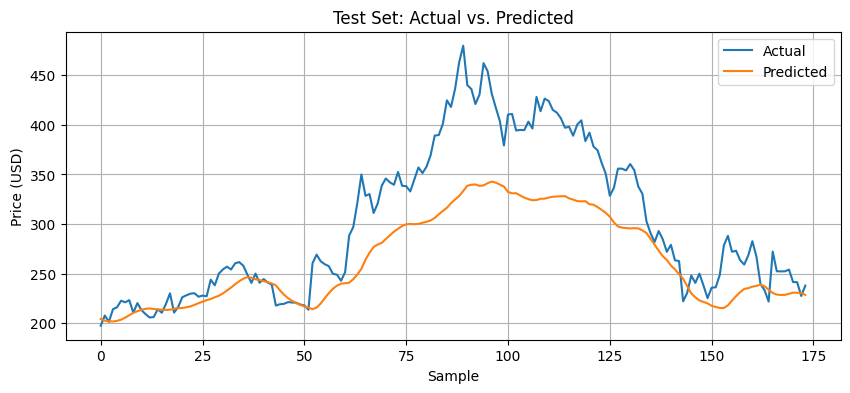

In [26]:
#@title Cell 9: Evaluate & Numeric RMSE (Fixed)
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import numpy as np

# 1) Predict (this stays the same)
y=model.predict(X_test)
y_pred = y[:,0]    # shape: (n_test,)
y_test = y_test.flatten()


# 2) Invert scaling *just* using the min/max of the Close column
#    original_scaled = (value - close_min) / (close_max - close_min)
#    so inverse is:
y_true_uv = y_test * (close_max - close_min) + close_min
y_pred_uv = y_pred * (close_max - close_min) + close_min

# 3) Compute RMSE numerically
rmse = np.sqrt(mean_squared_error(y_true_uv, y_pred_uv))
print(f"🔍 Test RMSE for {ticker}: {rmse:.4f}")

# 4) Plot actual vs. predicted
plt.figure(figsize=(10,4))
plt.plot(y_true_uv, label='Actual')
plt.plot(y_pred_uv, label='Predicted')
plt.title("Test Set: Actual vs. Predicted")
plt.xlabel("Sample")
plt.ylabel("Price (USD)")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
#@title Cell 10: N-Day-Ahead Forecast & Actual Check
import numpy as np
import pandas as pd
import yfinance as yf

# 1) Ask user how many days ahead to forecast
days = int(input("Enter number of days to forecast (1–7): "))
if not 1 <= days <= 7:
    raise ValueError("Please enter a value between 1 and 7.")

# 2) Prepare a rolling sequence of the last SEQ_LEN days
forecast_seq = scaled[-SEQ_LEN:].copy()        # shape = (SEQ_LEN, num_features)
preds_scaled = []

# 3) Iteratively predict and append
for _ in range(days):
    # predict next day's *scaled* close
    next_scaled = model.predict(forecast_seq.reshape(1, SEQ_LEN, num_features)).flatten()[0]
    preds_scaled.append(next_scaled)

    # construct a new feature-vector: copy last row, replace only the Close slot
    new_row = forecast_seq[-1].copy()
    new_row[target_idx] = next_scaled

    # shift window forward
    forecast_seq = np.vstack([forecast_seq[1:], new_row])

# 4) Invert scaling for closes
preds = [ps * (close_max - close_min) + close_min for ps in preds_scaled]

# 5) Display predictions
# Access the first element of the NumPy array in the preds list before formatting:
for i, price in enumerate(preds, start=1):
    print(f"🔮 Predicted close for day +{i}: ${price.item():.2f}") # changed to price.item()

# 6) Fetch & show the actual closes for those days
next_start = pd.to_datetime(end) + pd.Timedelta(days=1)
next_end   = next_start + pd.Timedelta(days=days - 1) + pd.Timedelta(days=1)
actual = yf.download(ticker, start=next_start, end=next_end)['Close']

print("\n📈 Actual closing prices:")
print(actual.to_string())

Enter number of days to forecast (1–7): 7
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
🔮 Predicted close for day +1: $193.25
🔮 Predicted close for day +2: $193.34
🔮 Predicted close for day +3: $193.41
🔮 Predicted close for day +4: $193.45
🔮 Predicted close for day +5: $193.47
🔮 Predicted close for day +6: $193.47
🔮 Predicted close for day +7: $193.46


[*********************100%***********************]  1 of 1 completed


📈 Actual closing prices:
Ticker            AAPL
Date                  
2025-04-23  204.600006


In [28]:
model.save('my_model.keras')


In [29]:
from google.colab import files
files.download('my_model.keras')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [30]:
import joblib
import os

os.makedirs("models", exist_ok=True)
joblib.dump(scaler, "models/scaler.save")

['models/scaler.save']

In [31]:
files.download("models/scaler.save")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>